In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#ML libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


# Loading Data

In [8]:
data_directory = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
ds_image_size = (128, 128)
batch_size = 32

train_dataset_ = image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=ds_image_size,
    batch_size=batch_size,
)

valid_dataset_ = image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=ds_image_size,
    batch_size=batch_size,
)

class_names = train_dataset_.class_names
num_classes = len(class_names)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [9]:
#normalize pixels 0.0 to 1.0 instead of 0 to 255
def convert_to_float(image, label): 
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    train_dataset_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    valid_dataset_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Using InceptionV3as a pretrained model

In [10]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
    layers.RandomTranslation(0.1, 0.1),
])


In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50

pretrained_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
pretrained_base.trainable=False

In [12]:
model = keras.Sequential([
    data_augmentation,
    pretrained_base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(6, activation='softmax')  # 6 classes
])

print(num_classes)

6


# Train

In [13]:
optimizer=tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
history=model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    callbacks=[early_stopping],
)

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.3286 - loss: 2.0425 - val_accuracy: 0.6119 - val_loss: 1.0474
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5847 - loss: 1.1450 - val_accuracy: 0.7287 - val_loss: 0.8053
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6455 - loss: 0.9948 - val_accuracy: 0.7525 - val_loss: 0.7110
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7011 - loss: 0.8330 - val_accuracy: 0.7564 - val_loss: 0.7109
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 997ms/step - accuracy: 0.7006 - loss: 0.8300 - val_accuracy: 0.7703 - val_loss: 0.6607
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 998ms/step - accuracy: 0.7335 - loss: 0.7663 - val_accuracy: 0.7743 - val_loss: 0.6350
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 987ms/step - accuracy: 0.7438 - loss: 0.6870 - val_accuracy: 0.7762 - val_loss: 0.6396
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 988ms/step - accuracy: 0.7561 - loss: 0.6890 - val_accuracy: 0.7782

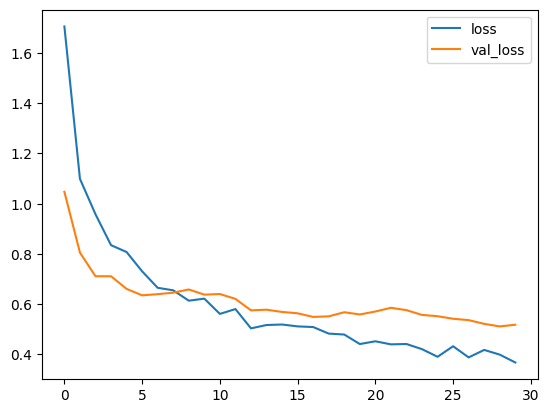

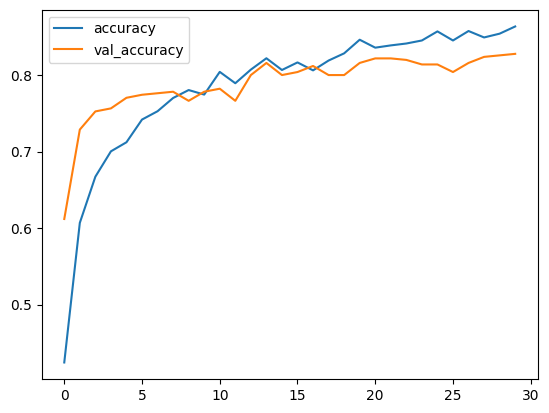

In [15]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();